In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import anndata
import time
import seaborn as sns

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [2]:
# Change the download base to where the files are
download_base = Path('./data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20250531/manifest.json'

In [3]:
abc_cache.list_data_files('MERFISH-C57BL6J-638850-imputed')
file = abc_cache.get_data_path(
    directory='MERFISH-C57BL6J-638850-imputed', file_name='C57BL6J-638850-imputed/log2')
print(file)

/Users/lindale/Downloads/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850-imputed/20240831/C57BL6J-638850-imputed-log2.h5ad


In [4]:
adata = anndata.read_h5ad(file, backed='r')
print(adata)

AnnData object with n_obs × n_vars = 4334174 × 8460 backed at '/Users/lindale/Downloads/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850-imputed/20240831/C57BL6J-638850-imputed-log2.h5ad'
    obs: 'brain_section_label'
    var: 'gene_symbol'


In [5]:
print("Number of genes = ", len(adata.var))
adata.var.index[0:5]

Number of genes =  8460


Index(['ENSMUSG00000026676', 'ENSMUSG00000024517', 'ENSMUSG00000029361',
       'ENSMUSG00000062372', 'ENSMUSG00000055639'],
      dtype='object', name='gene_identifier')

In [6]:
# Load cell annotations
cell_anno = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='cell_metadata_with_cluster_annotation',
    dtype={"cell_label": str, "neurotransmitter": str}
)
cell_anno.set_index('cell_label', inplace=True)
print("Loaded cell_anno columns:", list(cell_anno.columns))

Loaded cell_anno columns: ['brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color']


In [12]:
# Filter genes that start with "Aqp"
gene_filtered = adata.var[adata.var['gene_symbol'].str.startswith('Aqp')]

# Extract gene expression for the selected genes
gene_subset = adata[:, gene_filtered.index].to_df()

# Rename columns to gene symbols
gene_subset.rename(columns=gene_filtered.to_dict()['gene_symbol'], inplace=True)

print("Genes found in dataset:", list(gene_filtered.gene_symbol))


Genes found in dataset: ['Aqp4', 'Aqp11', 'Aqp5', 'Aqp6', 'Aqp1']


In [13]:
# Create list of target genes
target_genes = ['Aqp4', 'Aqp11', 'Aqp5', 'Aqp6', 'Aqp1']

# Select the desired imputed genes
pred = [x in target_genes for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]

# Extract gene expression for the selected genes
gene_subset = adata[:, gene_filtered.index].to_df()

# Rename columns to gene symbols
gene_subset.rename(columns=gene_filtered.to_dict()['gene_symbol'], inplace=True)
print("Genes found in dataset:", list(gene_filtered.gene_symbol))

Genes found in dataset: ['Aqp4', 'Aqp11', 'Aqp5', 'Aqp6', 'Aqp1']


In [14]:
print(cell_anno.columns.tolist())

['brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color']


In [15]:
# Merge expression with metadata
joined = cell_anno.join(gene_subset, on='cell_label')

# Check columns and values exist
for col in ['class', 'neurotransmitter', 'subclass']:
    if col in joined.columns:
        print(f"✅ Column '{col}' exists. Unique values:")
        print(joined[col].unique())
        print("-" * 50)
    else:
        print(f"⚠ Column '{col}' does NOT exist in joined dataframe!")

✅ Column 'class' exists. Unique values:
['04 DG-IMN Glut' '23 P Glut' '31 OPC-Oligo' '24 MY Glut' '19 MB Glut'
 '26 P GABA' '20 MB GABA' '05 OB-IMN GABA' '30 Astro-Epen' '33 Vascular'
 '27 MY GABA' '28 CB GABA' '09 CNU-LGE GABA' '01 IT-ET Glut' '12 HY GABA'
 '29 CB Glut' '11 CNU-HYa GABA' '13 CNU-HYa Glut' '03 OB-CR Glut'
 '34 Immune' '10 LSX GABA' '32 OEC' '02 NP-CT-L6b Glut' '08 CNU-MGE GABA'
 '07 CTX-MGE GABA' '15 HY Gnrh1 Glut' '25 Pineal Glut' '06 CTX-CGE GABA'
 '18 TH Glut' '14 HY Glut' '16 HY MM Glut' '21 MB Dopa' '17 MH-LH Glut'
 '22 MB-HB Sero']
--------------------------------------------------
✅ Column 'neurotransmitter' exists. Unique values:
[nan 'Glut' 'Chol' 'GABA-Glyc' 'GABA' 'Dopa' 'Glut-GABA' 'Hist' 'Sero'
 'Nora']
--------------------------------------------------
✅ Column 'subclass' exists. Unique values:
['038 DG-PIR Ex IMN' '235 PG-TRN-LRN Fat2 Glut' '327 Oligo NN'
 '261 HB Calcb Chol' '243 PGRN-PARN-MDRN Hoxb5 Glut' '157 RN Spp1 Glut'
 '177 SCig-an-PPT Foxb1 Glut

In [16]:
# Filter check
filters = {
    'class': '08 CNU-MGE GABA',
    'neurotransmitter': 'Chol',
    'subclass': 'SI'
}
for col, val in filters.items():
    if col in joined.columns:
        if val in joined[col].unique():
            print(f"✅ Value '{val}' exists in column '{col}'")
        else:
            print(f"⚠ Value '{val}' NOT found in column '{col}'")

✅ Value '08 CNU-MGE GABA' exists in column 'class'
✅ Value 'Chol' exists in column 'neurotransmitter'
⚠ Value 'SI' NOT found in column 'subclass'


In [17]:
# Apply filters
filtered = joined[
    (joined['class'] == '08 CNU-MGE GABA') &
    (joined['neurotransmitter'] == 'Chol')
]

print("Number of cells after filtering:", len(filtered))
print("Unique subclasses:", filtered['subclass'].unique())
print("Brain sections in filtered data:", filtered['brain_section_label'].unique()[:10])

Number of cells after filtering: 2858
Unique subclasses: ['058 PAL-STR Gaba-Chol']
Brain sections in filtered data: ['C57BL6J-638850.51' 'C57BL6J-638850.54' 'C57BL6J-638850.44'
 'C57BL6J-638850.45' 'C57BL6J-638850.46' 'C57BL6J-638850.47'
 'C57BL6J-638850.43' 'C57BL6J-638850.50' 'C57BL6J-638850.38'
 'C57BL6J-638850.49']


Selected brain sections: ['C57BL6J-638850.54', 'C57BL6J-638850.53', 'C57BL6J-638850.52', 'C57BL6J-638850.51', 'C57BL6J-638850.50', 'C57BL6J-638850.49', 'C57BL6J-638850.48', 'C57BL6J-638850.47', 'C57BL6J-638850.46', 'C57BL6J-638850.45', 'C57BL6J-638850.44']
Number of cells after filtering for all slices: 2398
Unique sections in filtered data: ['C57BL6J-638850.51' 'C57BL6J-638850.54' 'C57BL6J-638850.44'
 'C57BL6J-638850.45' 'C57BL6J-638850.46' 'C57BL6J-638850.47'
 'C57BL6J-638850.50' 'C57BL6J-638850.49' 'C57BL6J-638850.52'
 'C57BL6J-638850.48']


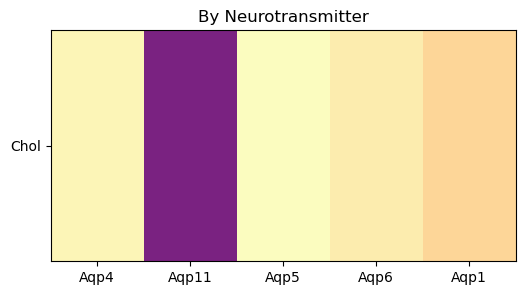

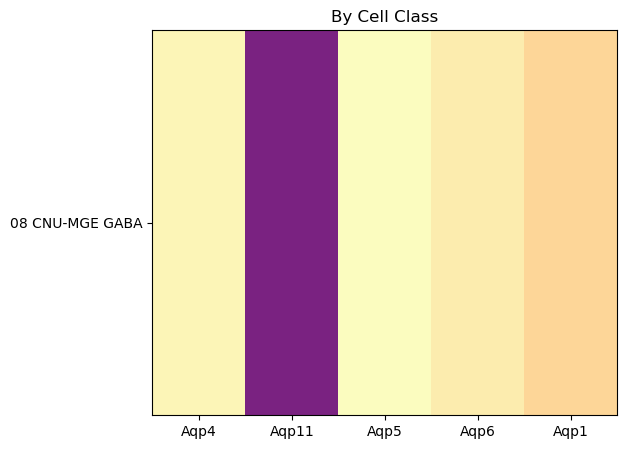

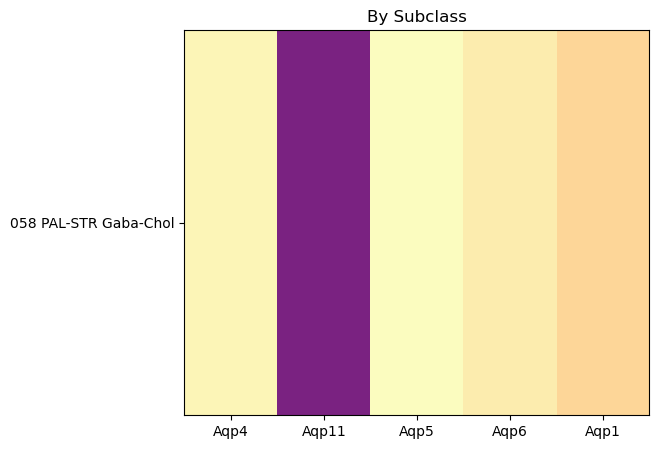

In [18]:
blist = [f'C57BL6J-638850.{i}' for i in range(54, 43, -1)]
print("Selected brain sections:", blist)

# Filter to include those slices
filtered_all = joined[
    (joined['class'] == '08 CNU-MGE GABA') &
    (joined['neurotransmitter'] == 'Chol') &
    (joined['brain_section_label'].isin(blist))
]

print(f"Number of cells after filtering for all slices: {len(filtered_all)}")
print("Unique sections in filtered data:", filtered_all['brain_section_label'].unique())

# Aggregation by metadata using all 10 slices
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap = plt.cm.magma_r, vmin = 0, vmax = 5):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width,fig_height)

    res = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
final_genes = [g for g in target_genes if g in filtered_all.columns]

agg_nt = aggregate_by_metadata(filtered_all, final_genes, 'neurotransmitter', True)
plot_heatmap(agg_nt, 6, 3, vmax=3)
plt.title("By Neurotransmitter")
plt.show()

agg_class = aggregate_by_metadata(filtered_all, final_genes, 'class', True)
plot_heatmap(agg_class, 6, 5, vmax=3)
plt.title("By Cell Class")
plt.show()

agg_subclass = aggregate_by_metadata(filtered_all, final_genes, 'subclass', True)
plot_heatmap(agg_subclass, 6, 5, vmax=3)
plt.title("By Subclass")
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


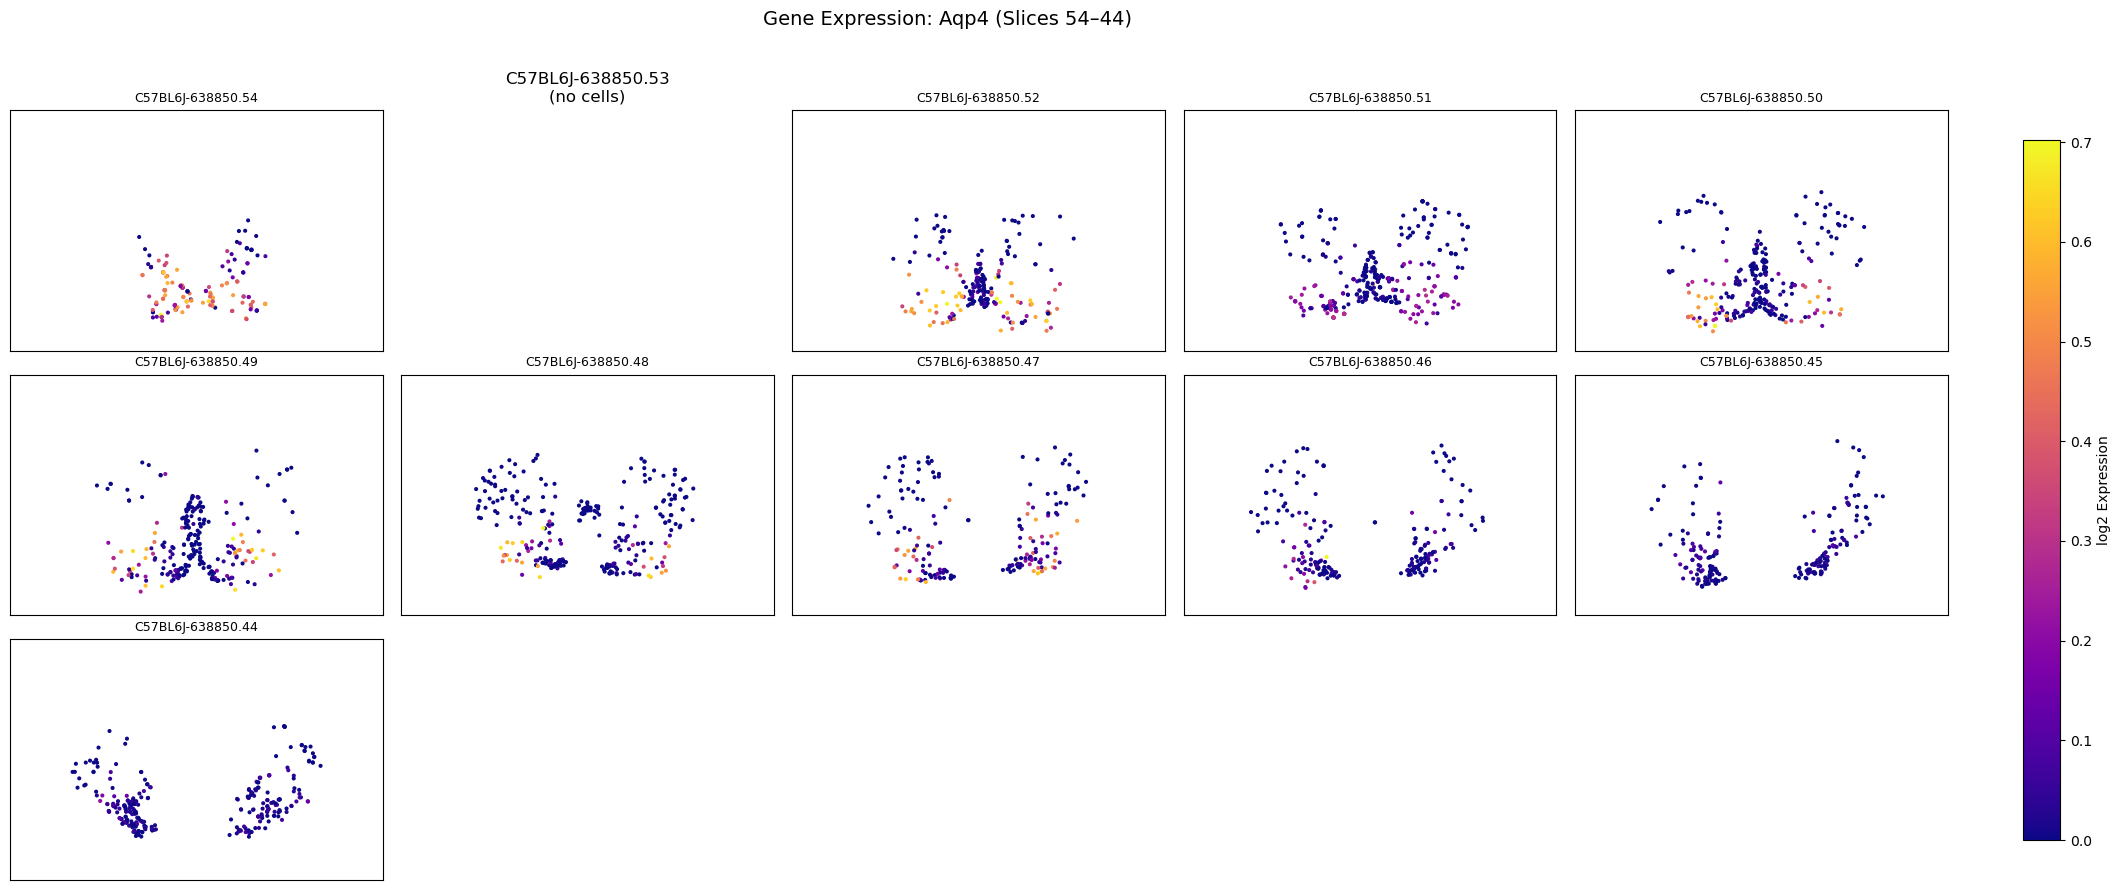

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


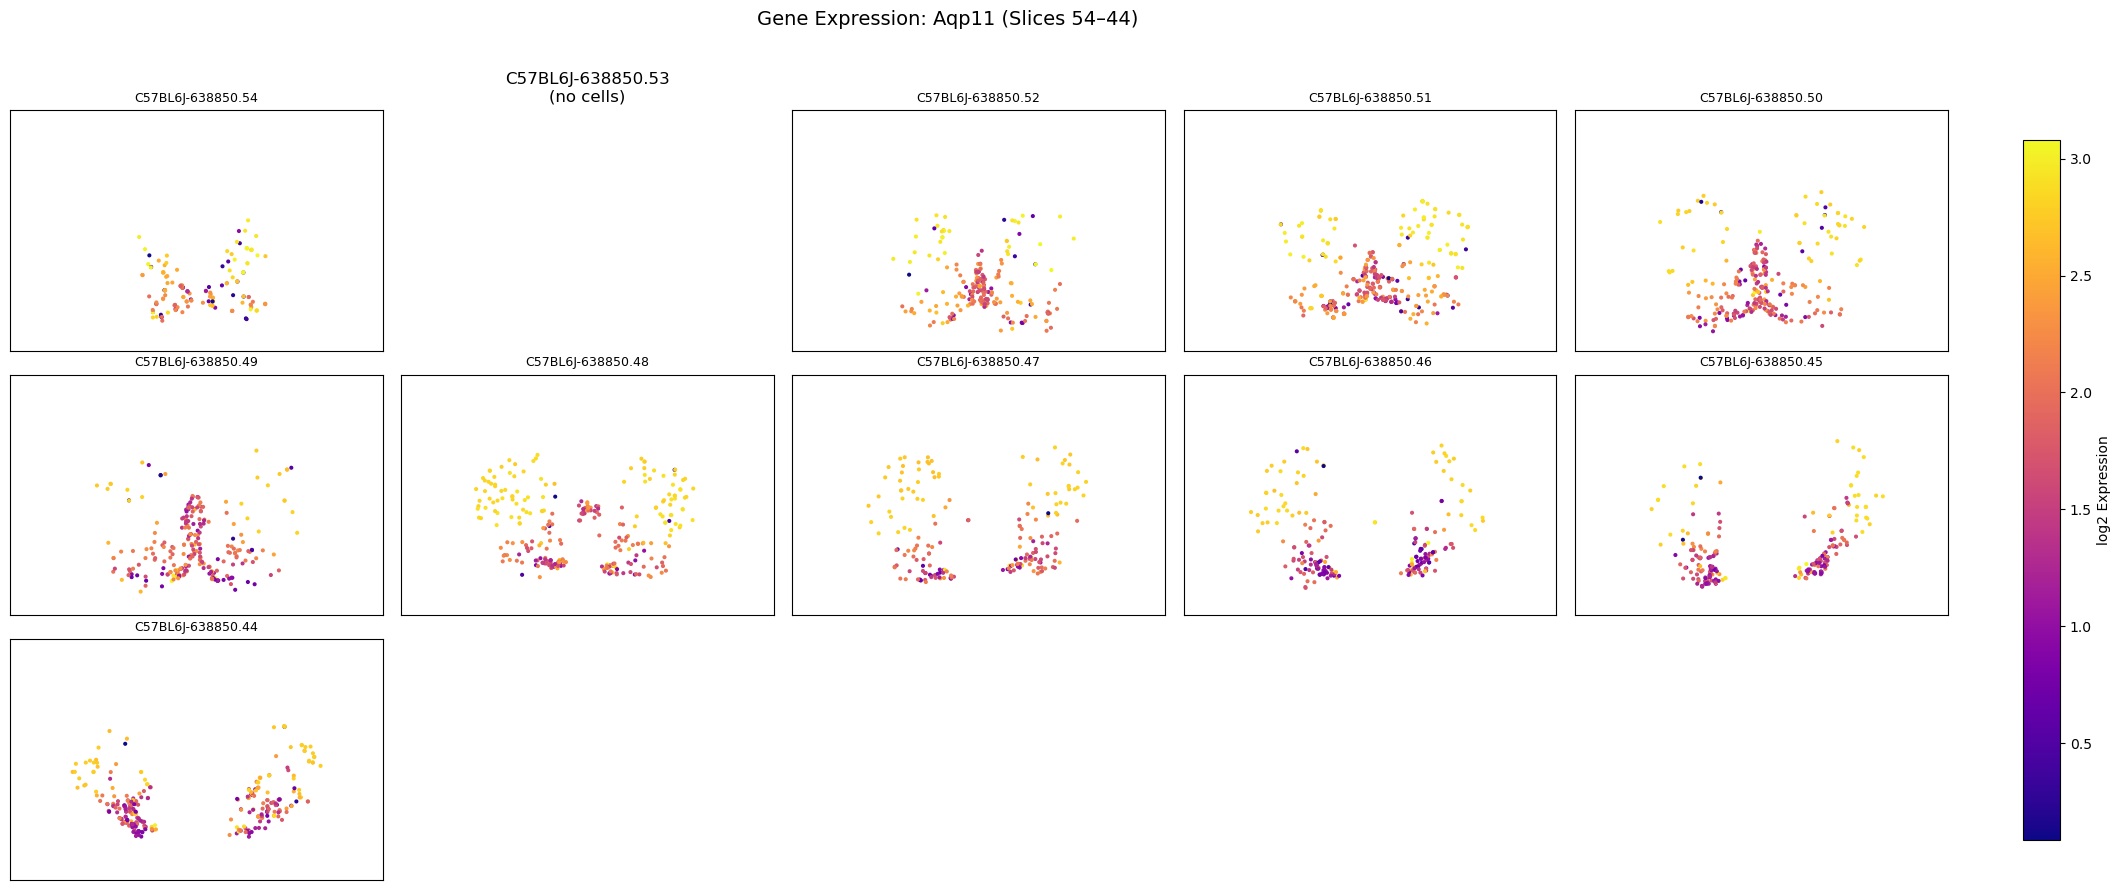

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


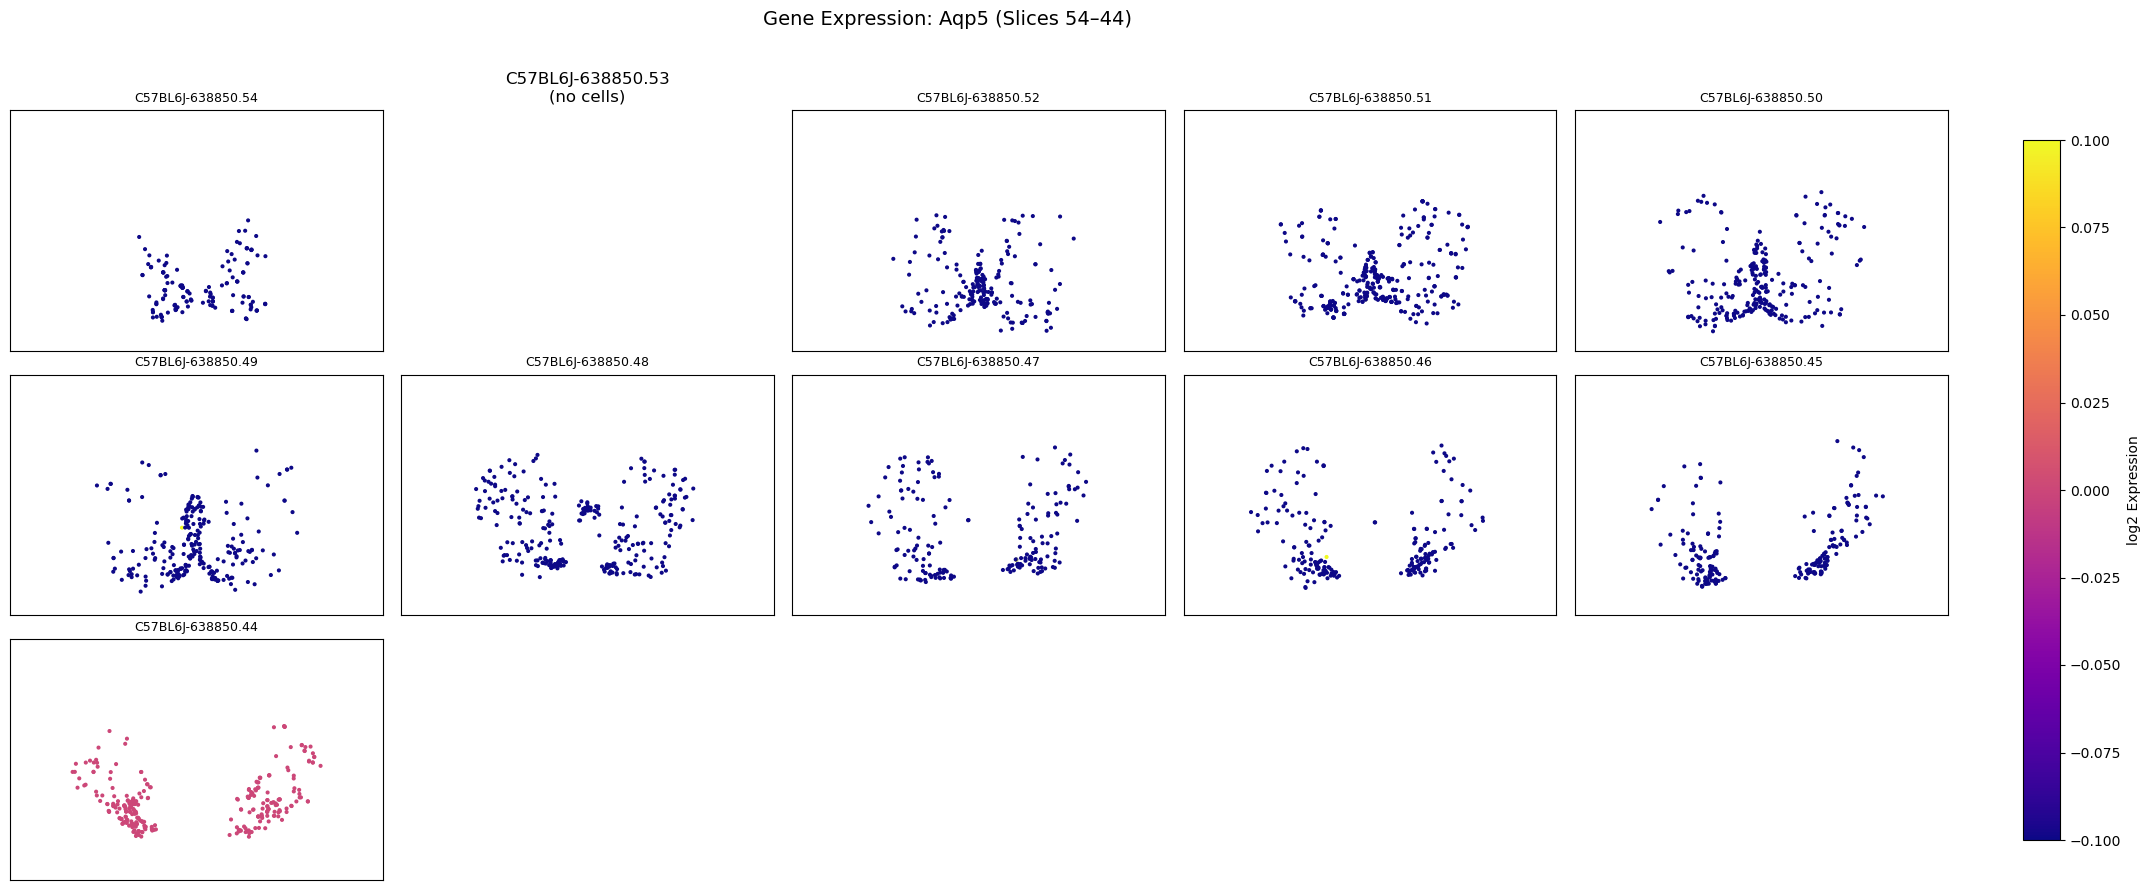

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


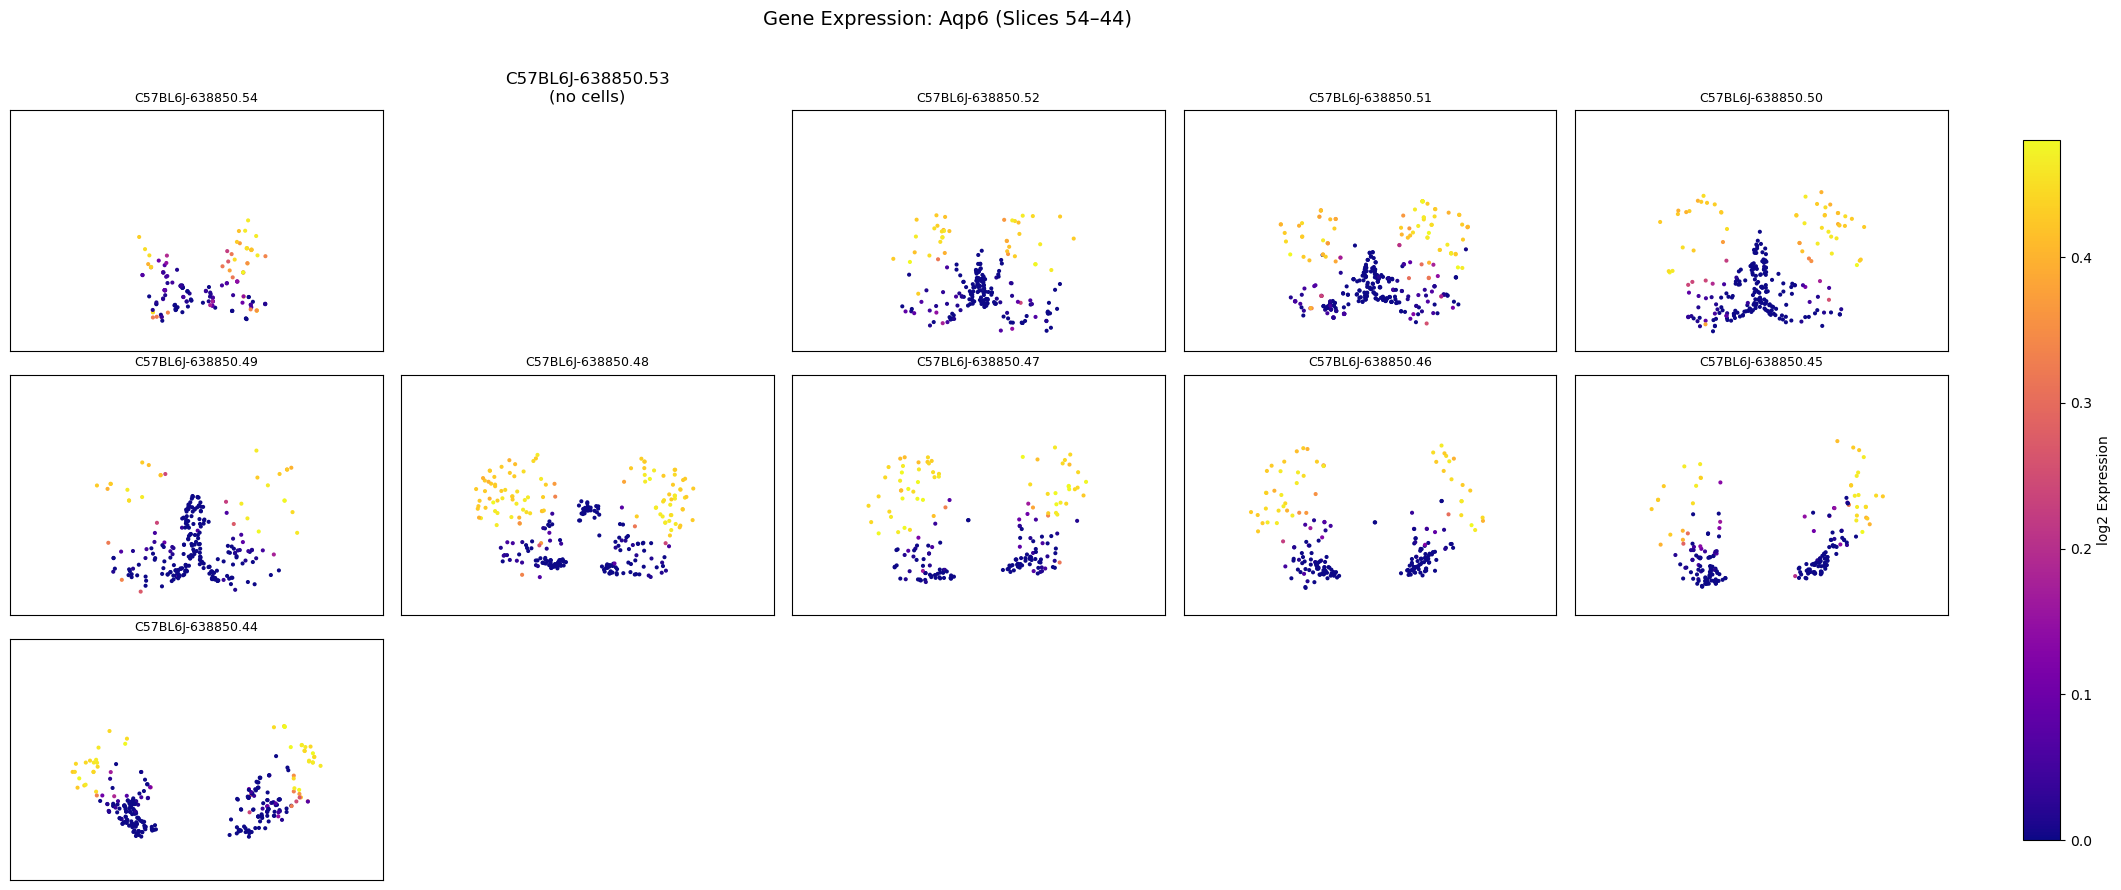

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


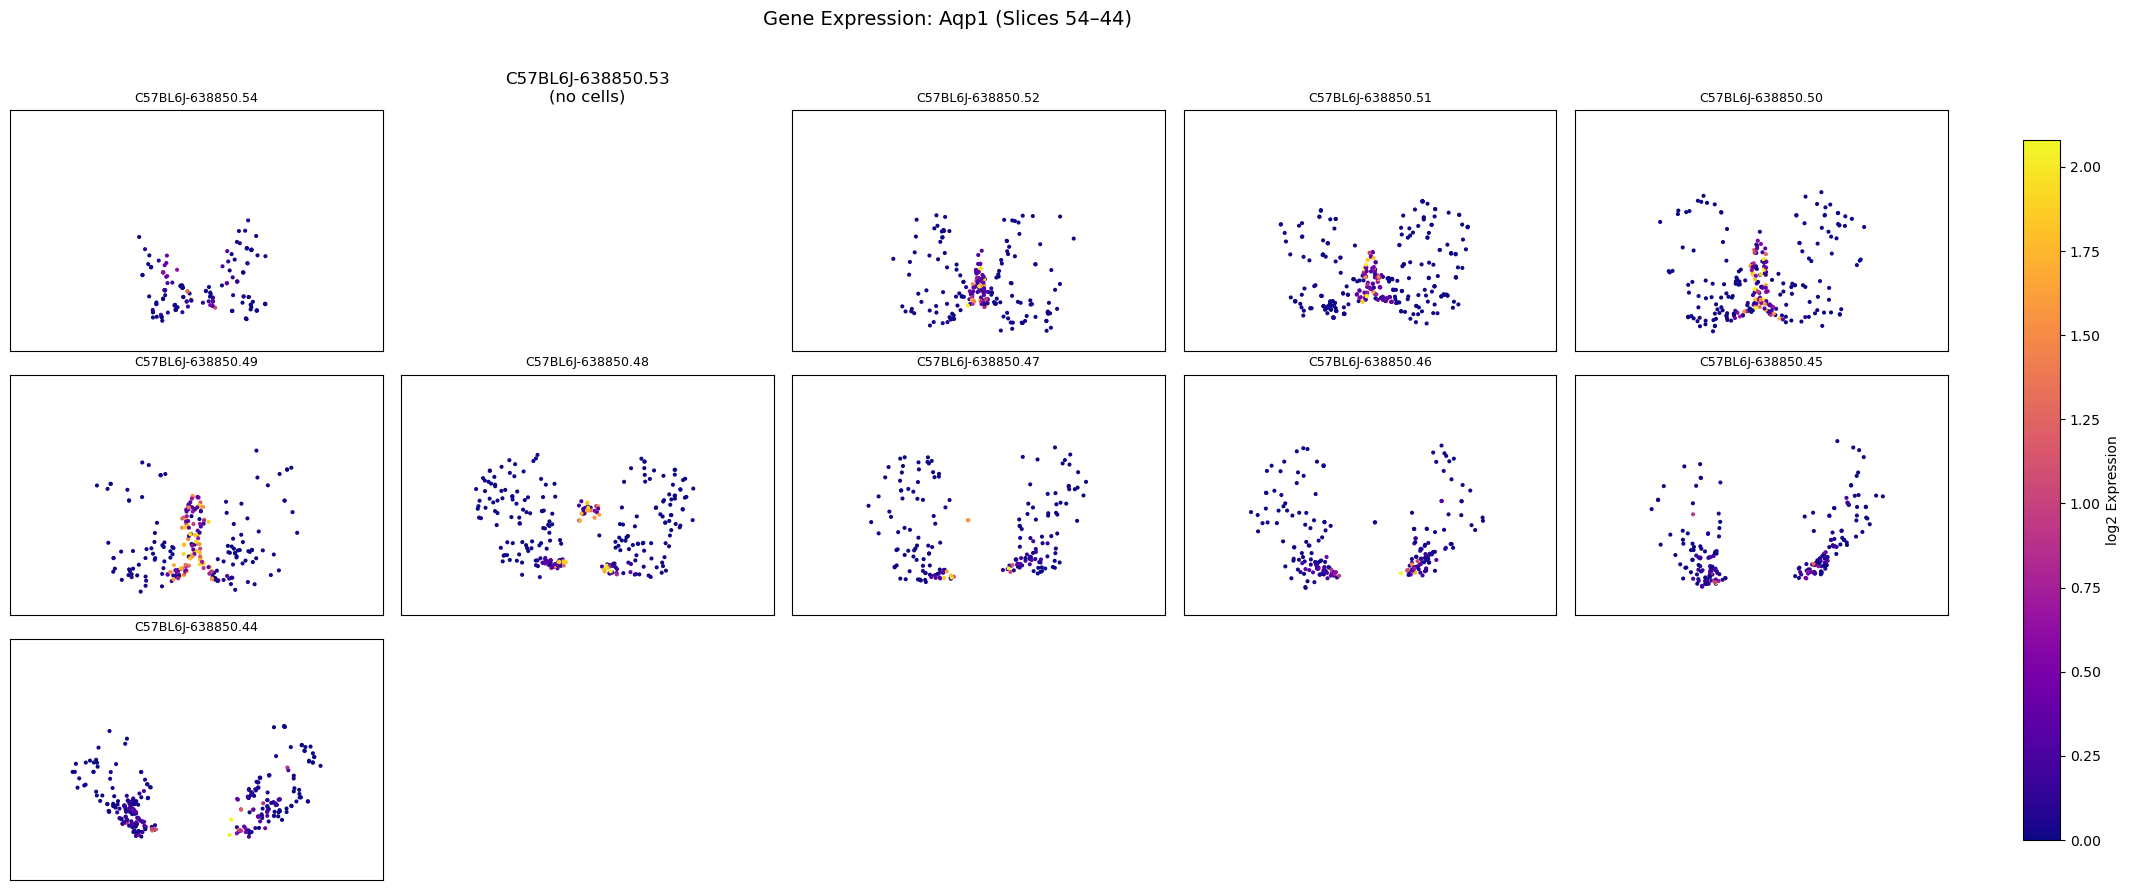

In [19]:
# Spatial plots for all slices (in a 2x5 grid)
def plot_sections_grid(df, feature, blist, cmap=plt.cm.magma_r, fig_width=25, fig_height=10):
    n_slices = len(blist)
    ncols = 5
    nrows = int(np.ceil(n_slices / ncols))
    fig, ax = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
    ax = ax.flatten()

    for idx, bsl in enumerate(blist):
        filtered = df[df['brain_section_label'] == bsl]
        if filtered.empty:
            ax[idx].set_title(f"{bsl}\n(no cells)")
            ax[idx].axis("off")
            continue
        xx, yy, vv = filtered['x'], filtered['y'], filtered[feature]
        # Larger dot size for better visibility
        sc = ax[idx].scatter(xx, yy, s=15.0, c=vv, cmap=cmap, marker=".")
        ax[idx].axis('equal')
        ax[idx].set_xlim(0, 11)
        ax[idx].set_ylim(11, 0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].set_title(bsl, fontsize=9)

    # Hide any unused subplots
    for j in range(idx + 1, len(ax)):
        ax[j].axis("off")

    # Add colorbar to the right of all plots
    cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
    fig.colorbar(sc, cax=cbar_ax, label='log2 Expression')
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    return fig, ax

# Plot each gene across all 10 slices
for g in target_genes:
    if g in filtered_all.columns:
        fig, ax = plot_sections_grid(filtered_all, g, blist, cmap=plt.cm.plasma) 
        fig.suptitle(f"Gene Expression: {g} (Slices 54–44)", fontsize=14)
        plt.show()


In [20]:
# Compute mean and standard deviation for filtered cells
summary_stats = (
    filtered_all  # use your fully filtered dataset
    .groupby(['brain_section_label', 'class'])[target_genes]
    .agg(['mean', 'std'])
    .reset_index()
)

# Flatten MultiIndex columns
summary_stats.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0]
    for col in summary_stats.columns
]

print("\nSummary statistics (mean ± std) for class CNU-MGE GABA with Chol neurotransmitter:")
print(summary_stats.head())



Summary statistics (mean ± std) for class CNU-MGE GABA with Chol neurotransmitter:
  brain_section_label            class  Aqp4_mean  Aqp4_std  Aqp11_mean  \
0   C57BL6J-638850.44  08 CNU-MGE GABA   0.027116  0.054168    1.906768   
1   C57BL6J-638850.45  08 CNU-MGE GABA   0.034339  0.072775    1.774333   
2   C57BL6J-638850.46  08 CNU-MGE GABA   0.033594  0.072844    1.903516   
3   C57BL6J-638850.47  08 CNU-MGE GABA   0.051759  0.082308    2.094365   
4   C57BL6J-638850.48  08 CNU-MGE GABA   0.026600  0.064995    2.123485   

   Aqp11_std  Aqp5_mean  Aqp5_std  Aqp6_mean  Aqp6_std  Aqp1_mean  Aqp1_std  
0   0.704064   0.000000  0.000000   0.088006  0.167737   0.151800  0.274423  
1   0.652630   0.000000  0.000000   0.090216  0.168795   0.131833  0.241363  
2   0.659438   0.000886  0.012846   0.119004  0.191065   0.147632  0.313704  
3   0.594277   0.000010  0.000136   0.160374  0.207212   0.151711  0.420804  
4   0.621895   0.000000  0.000000   0.185760  0.218631   0.258155  0.583832

/var/folders/gs/nsc53bv90r1ghqzzq7v837sw0000gn/T/ipykernel_68204/914436334.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


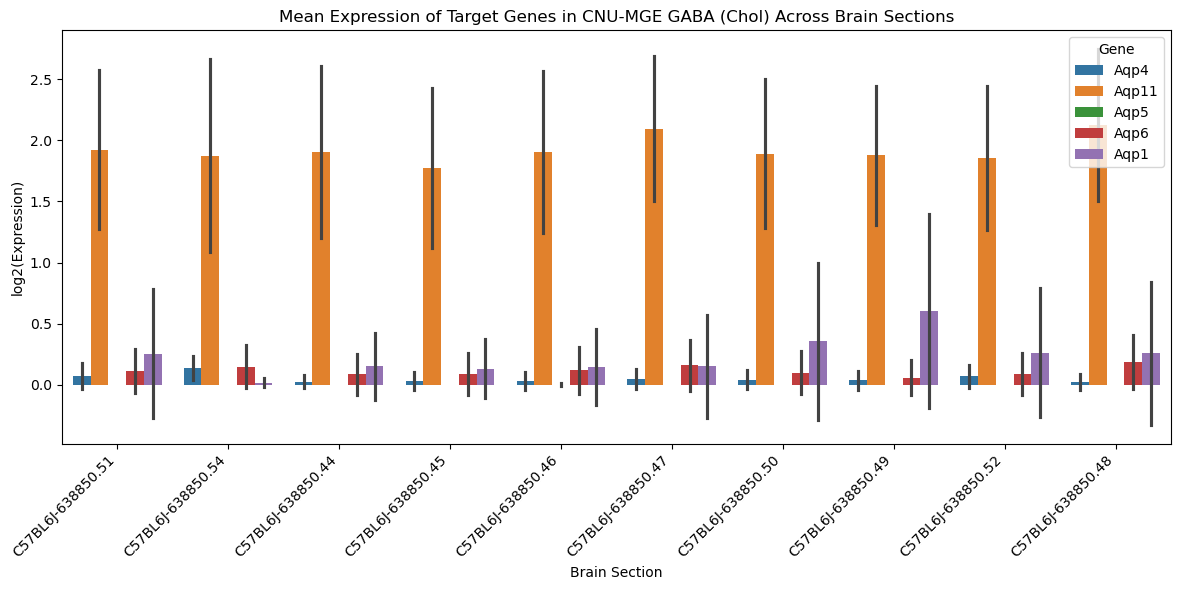

In [21]:
# Melt the summary for plotting
summary_melted = filtered_all.melt(
    id_vars=['brain_section_label', 'class'],
    value_vars=target_genes,
    var_name='Gene',
    value_name='Expression'
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_melted,
    x='brain_section_label',
    y='Expression',
    hue='Gene',
    ci='sd'  # Use standard deviation for error bars
)
plt.title('Mean Expression of Target Genes in CNU-MGE GABA (Chol) Across Brain Sections')
plt.ylabel('log2(Expression)')
plt.xlabel('Brain Section')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gene')
plt.tight_layout()
plt.show()